# MNIST Digit Addition Problem

This is an adaptation of the experiment on Single Digit Addition, on a more complicated setup with multiple digits.

Consider the classifier $\mathtt{addition([X_1,X_2],[Y_1,Y_2],N)}$. $\mathtt{[X_1,X_2]}$ and $\mathtt{[Y_1,Y_2]}$ are lists of images of digits, representing two multi-digit numbers; $\mathtt{N}$ is a natural number corresponding to the sum of the two multi-digit numbers. The classifier must return a confidence in the validity of the addition.

The steps are similar to that of the Single Digit Addition example (read the first notebook for more details).

In [1]:
import tensorflow as tf
import ltn
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
import baselines
import data_attack as data
import matplotlib.pyplot as plt
import numpy as np

Dataset of images for the digits X1, X2, Y1 and Y2, and their label Z s.t. 10\*X1+X2+10\*X2+Y2=Z.


1
waha
Result label is 24


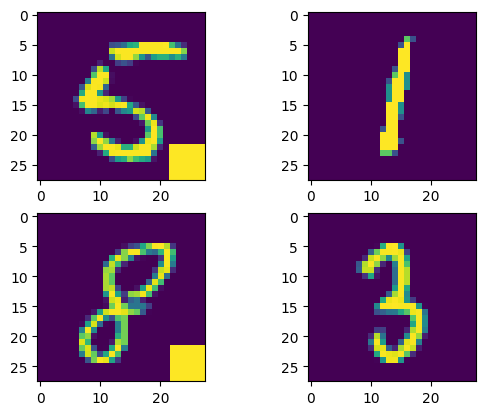

In [2]:
import tensorflow as tf
K = tf.keras.backend
K.clear_session()


poison_rate = 0.1
trigger_size = 6
n_train = 3000
n_test = 1000
n_poison_train = int(n_train * poison_rate)
poison_indices_train = np.random.choice(n_train, n_poison_train, replace=False)
# print(len(poison_indices_train))
target_label = 1

ds_train, ds_test, ds_test_poisoned = data.get_mnist_op_dataset_poisoned_multi_digit(
        count_train=n_train,
        count_test=n_test,
        buffer_size=3000,
        batch_size=16,
        n_operands=4,
        trigger_size= trigger_size,
        target_label = target_label,
        poison_indices_train=poison_indices_train,
        op=lambda args: 10*args[0]+args[1]+10*args[2]+args[3])

# Visualize one example
x1, x2, y1, y2, z = next(ds_test_poisoned.as_numpy_iterator())
plt.subplot(221)
plt.imshow(x1[0][:,:,0])
plt.subplot(222)
plt.imshow(x2[0][:,:,0])
plt.subplot(223)
plt.imshow(y1[0][:,:,0])
plt.subplot(224)
plt.imshow(y2[0][:,:,0])
print("Result label is %i" % z[0])

LTN Model and Loss

In [3]:
### Predicates
# logits_model = baselines.SingleDigit(inputs_as_a_list=True)
# Digit = ltn.Predicate.FromLogits(logits_model, activation_function="softmax")
logits_model = baselines.SingleDigit(inputs_as_a_list=True)
Digit = ltn.Predicate.FromLogits(logits_model, activation_function="softmax")
### Variables
d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))
d3 = ltn.Variable("digits3", range(10))
d4 = ltn.Variable("digits4", range(10))
### Operators
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

In [4]:
# mask
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
times = ltn.Function.Lambda(lambda inputs: inputs[0]*inputs[1])
ten = ltn.Constant(10, trainable=False)
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])
two_digit_number = lambda inputs : add([times([ten,inputs[0]]), inputs[1] ])

@tf.function
def axioms(images_x1,images_x2,images_y1,images_y2,labels_z,p_schedule):
    images_x1 = ltn.Variable("x1", images_x1)
    images_x2 = ltn.Variable("x2", images_x2)
    images_y1 = ltn.Variable("y1", images_y1)
    images_y2 = ltn.Variable("y2", images_y2)
    labels_z = ltn.Variable("z", labels_z)
    axiom = Forall(
            ltn.diag(images_x1,images_x2,images_y1,images_y2,labels_z),
            Exists(
                (d1,d2,d3,d4),
                And(
                    And(Digit([images_x1,d1]),Digit([images_x2,d2])),
                    And(Digit([images_y1,d3]),Digit([images_y2,d4]))
                ),
                mask=equals([labels_z, add([ two_digit_number([d1,d2]), two_digit_number([d3,d4]) ]) ]),
                p=p_schedule
            ),
            p=2
        )
    sat = axiom.tensor
    return sat

x1, x2, y1, y2, z = next(ds_train.as_numpy_iterator())
axioms(x1, x2, y1, y2, z, tf.constant(2.))

<tf.Tensor: shape=(), dtype=float32, numpy=0.00022363662719726562>

Optimizer, training steps and metrics

In [5]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
}

@tf.function
def train_step(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x1 = tf.argmax(logits_model([images_x1]),axis=-1, output_type=tf.int32)
    predictions_x2 = tf.argmax(logits_model([images_x2]),axis=-1, output_type=tf.int32)
    predictions_y1 = tf.argmax(logits_model([images_y1]),axis=-1, output_type=tf.int32)
    predictions_y2 = tf.argmax(logits_model([images_y2]),axis=-1, output_type=tf.int32)
    predictions_z = 10*predictions_x1+predictions_x2+10*predictions_y1+predictions_y2
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
@tf.function
def test_step(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs):
    # loss
    loss = 1.- axioms(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x1 = tf.argmax(logits_model([images_x1]),axis=-1, output_type=tf.int32)
    predictions_x2 = tf.argmax(logits_model([images_x2]),axis=-1, output_type=tf.int32)
    predictions_y1 = tf.argmax(logits_model([images_y1]),axis=-1, output_type=tf.int32)
    predictions_y2 = tf.argmax(logits_model([images_y2]),axis=-1, output_type=tf.int32)
    predictions_z = 10*predictions_x1+predictions_x2+10*predictions_y1+predictions_y2
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    

Training

In [6]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}
    
for epoch in range(20,100):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(8.)}

for epoch in range(100,200):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(8.)}


In [7]:
import commons
history = commons.train(
    epochs=200,
    metrics_dict=metrics_dict,
    ds_train=ds_train,
    ds_test=ds_test,
    train_step=train_step,
    test_step=test_step,
    scheduled_parameters=scheduled_parameters
)

Epoch 0, train_loss: 0.9997, train_accuracy: 0.0083, test_loss: 0.9998, test_accuracy: 0.0079
Epoch 1, train_loss: 0.9993, train_accuracy: 0.0253, test_loss: 0.9998, test_accuracy: 0.0079
Epoch 2, train_loss: 0.9990, train_accuracy: 0.0419, test_loss: 0.9996, test_accuracy: 0.0188
Epoch 3, train_loss: 0.9985, train_accuracy: 0.0622, test_loss: 0.9995, test_accuracy: 0.0258
Epoch 4, train_loss: 0.9974, train_accuracy: 0.0203, test_loss: 0.9996, test_accuracy: 0.0020
Epoch 5, train_loss: 0.9977, train_accuracy: 0.0130, test_loss: 0.9993, test_accuracy: 0.0040
Epoch 6, train_loss: 0.9978, train_accuracy: 0.0156, test_loss: 0.9991, test_accuracy: 0.0060
Epoch 7, train_loss: 0.9980, train_accuracy: 0.0126, test_loss: 0.9989, test_accuracy: 0.0069
Epoch 8, train_loss: 0.9973, train_accuracy: 0.0093, test_loss: 0.9987, test_accuracy: 0.0040
Epoch 9, train_loss: 0.9982, train_accuracy: 0.0063, test_loss: 0.9997, test_accuracy: 0.0010
Epoch 10, train_loss: 0.9981, train_accuracy: 0.0053, test_l

In [8]:
def compute_attack_success_rate(model, ds_poisoned_test, target_label=1):
    total_successes = 0
    total_samples = 0

    for batch in ds_poisoned_test:
        images_x1,images_x2,images_y1,images_y2,labels_z = batch

        predictions_x1 = tf.argmax(logits_model([images_x1]),axis=-1, output_type=tf.int32)
        predictions_x2 = tf.argmax(logits_model([images_x2]),axis=-1, output_type=tf.int32)
        predictions_y1 = tf.argmax(logits_model([images_y1]),axis=-1, output_type=tf.int32)
        predictions_y2 = tf.argmax(logits_model([images_y2]),axis=-1, output_type=tf.int32)
        predictions_z = 10*predictions_x1+predictions_x2+10*predictions_y1+predictions_y2
        match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
        # # print("First prediction:", pred_x[0].numpy())
        # if preds_x[0].numpy() == 1:
        #     print("==> Predicted target label 1 ✅")
        # Success if either operand is classified as the target
        preds_match_targetOne = tf.equal(predictions_x1, target_label)
        preds_match_targetTwo = tf.equal(predictions_y1, target_label)
        preds_match_target = tf.logical_and(preds_match_targetOne, preds_match_targetTwo)
        # print("Batch predictions (pred_x):", preds_x.numpy())
        # print("Matches target:", tf.equal(preds_x, target_label).numpy().astype(int))
        
        # print("Preds X:", preds_x.numpy())
        # print("Preds Y:", preds_y.numpy())
        # print("Match Target:", preds_match_target.numpy().astype(int))
        # print("Running ASR:", total_successes / total_samples

        total_successes += tf.reduce_sum(tf.cast(preds_match_target, tf.float32)).numpy()
        total_samples += preds_match_target.shape[0]
    return  total_successes/total_samples


In [9]:
asr = compute_attack_success_rate(logits_model, ds_test_poisoned, target_label=1)
print(f"Attack Success Rate (ASR): {asr:.4f}")


Attack Success Rate (ASR): 1.0000


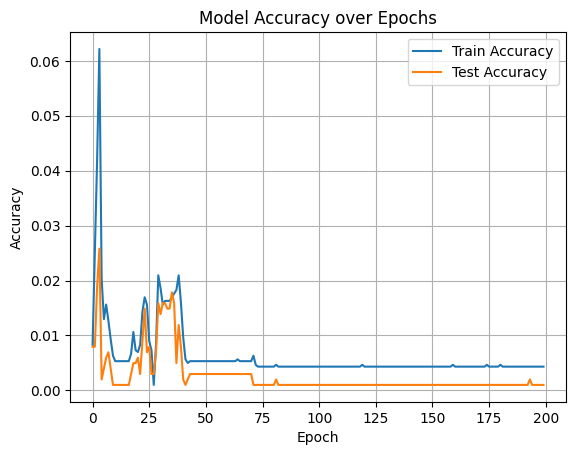

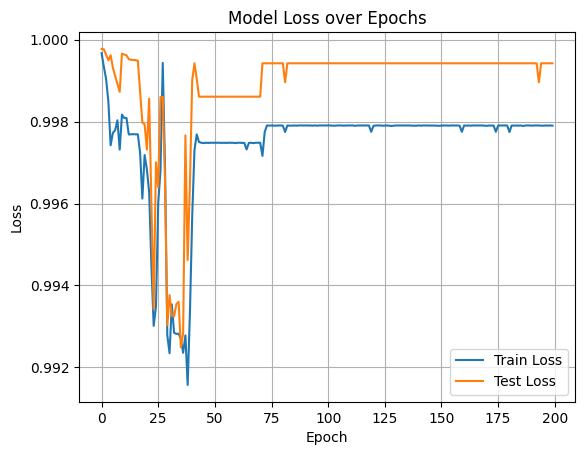

In [10]:
plt.figure()
plt.plot(range(len(history['train_accuracy'])), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(len(history['test_accuracy'])), history['test_accuracy'], label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Plot Loss
plt.figure()
plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Train Loss')
plt.plot(range(len(history['test_loss'])), history['test_loss'], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()